In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm

# Hamiltonian
Here, we consider the Hamiltonian
\begin{align*}
    H = &\sum_{\langle i, j\rangle} \vec D_{ij} \cdot \left(\vec \sigma_i \times\vec \sigma_j\right)
        + \sum_{\langle i, j\rangle} J_{ij} \vec \sigma_i \cdot \vec \sigma_j
        + B \sum_i \sigma_i^z.
\end{align*}
where $\vec D_{ij}=D\hat z$ for nearest-neighbor bonds $\langle i,j \rangle$ and zero elsewise, and similarly $J_{ij}=J$ for $\langle i, j\rangle$ nearest-neighbors. For now, I will set $B=0$.


Nvmnd it's a JK! The paper I'm duplicating ([this one](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.103.L060404)) orients $\vec D_{ij}$ to be perpendicular to the direction (in real space) of the bond between sites $i$ and $j$.

The triangular lattice has primitive vectors
\begin{equation}
\vec a_1 = \begin{pmatrix} 1 \\ 0 \end{pmatrix},
\quad
\vec a_2 = \begin{pmatrix} \frac{1}{2} \\ \frac{\sqrt{3}}{2} \end{pmatrix}.
\end{equation}
Each site on the lattice is connected to its six nearest neighbors by a linear combination of these vectors.

In [2]:
# general code

def skyrmion_hamiltonian(D, J, h, L, bonds, perps, basis):
    x = np.array([0., 1.])
    y = np.array([1., 0.])
    dm_interactions = [['yz', [[D*np.vdot(x, perps[i]), b[0], b[1]] 
                                for i, b in enumerate(bonds)]],
                       ['zy', [[-D*np.vdot(x, perps[i]), b[0], b[1]] 
                                for i, b in enumerate(bonds)]],
                       ['zx', [[D*np.vdot(y, perps[i]), b[0], b[1]] 
                                for i, b in enumerate(bonds)]],
                       ['xz', [[-D*np.vdot(y, perps[i]), b[0], b[1]] 
                                for i, b in enumerate(bonds)]]]
    heisen_interactions = [[d, [[J, b[0], b[1]] for b in bonds]]
                            for d in ['xx', 'yy', 'zz']]
    zeeman = [['z', [[-h, i] for i in range(L)]]]
    return quantum_operator({'static': dm_interactions + heisen_interactions + zeeman},
                            basis=basis, check_symm=False, check_herm=False)

def Mz_op(L, basis):
    return quantum_operator({'static': [['z', [[1./L, i] for i in range(L)]]]}, 
                            basis=basis)

def chi_op(tris, basis):
    l = len(tris)
    n = 1./l
    return quantum_operator({'static': [['xyz', [[n,t[0],t[1],t[2]] for t in tris]],
                                        ['xzy', [[-n,t[0],t[1],t[2]] for t in tris]],
                                        ['yzx', [[n,t[0],t[1],t[2]] for t in tris]],
                                        ['yxz', [[-n,t[0],t[1],t[2]] for t in tris]],
                                        ['zxy', [[n,t[0],t[1],t[2]] for t in tris]],
                                        ['zyx', [[-n,t[0],t[1],t[2]] for t in tris]]]}, 
                            basis=basis)

In [30]:
a1 = np.array([1.,0])
a2 = np.array([0.5, np.sqrt(3)/2])
u = a1
v = a2-a1
w = -a2
up = np.array([0, 1.])
vp = np.array([-np.sqrt(3)/2, -0.5])
wp = np.array([np.sqrt(3)/2, -0.5])

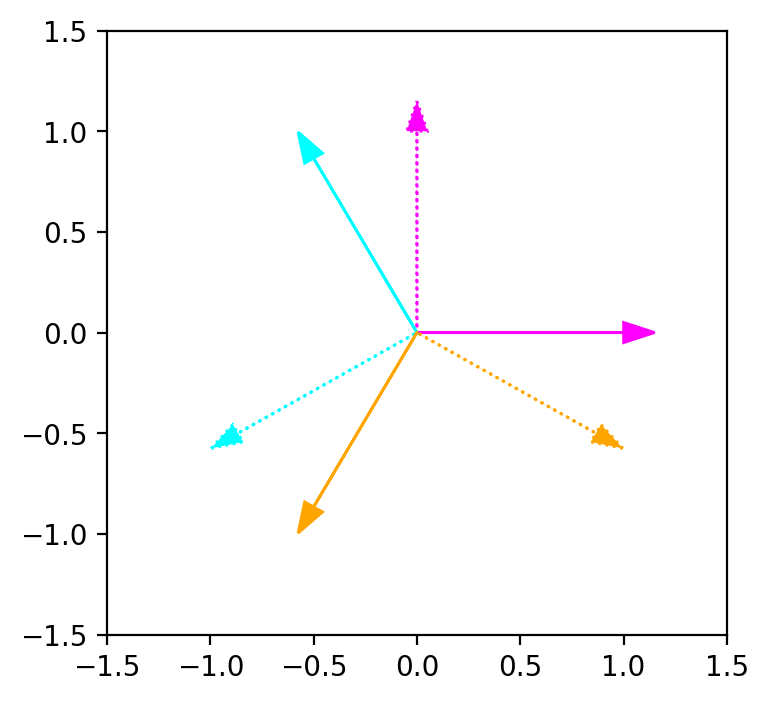

In [31]:
plt.figure(figsize=(4,4), dpi=200)
plt.arrow(0, 0, u[0], u[1], color='magenta', head_width=.1)
plt.arrow(0, 0, up[0], up[1], color='magenta', head_width=.1, ls=':')

plt.arrow(0, 0, v[0], v[1], color='cyan', head_width=.1)
plt.arrow(0, 0, vp[0], vp[1], color='cyan', head_width=.1, ls=':')

plt.arrow(0, 0, w[0], w[1], color='orange', head_width=.1)
plt.arrow(0, 0, wp[0], wp[1], color='orange', head_width=.1, ls=':')

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

# 3-site cluster

First, let's just write the vectors for the bonds on our 3-site cluster below:

            <0>-<1>-<2>
            / \ / \ / \
          <1>- 2 -<0>-<1>
          / \ / \ / \ /
        <2>- 0 - 1 -<2>-
          \ / \ / \ / \
          <1>-<2>-<0>-<1>
          
The ones within the cluster are:
\begin{align}
\vec r_{01}^0 = \vec a_1, \quad
\vec r_{12}^0 = \vec a_2 - \vec a_1, \quad
\vec r_{20}^0 = -\vec a_2.
\end{align}
Each pair of nearest-neighbors in the lattice is connected by one of these vectors! I'm going to give these directions names:
\begin{align}
\hat u =& \vec a_1\\
\hat v =& \vec a_2-\vec a_1\\
\hat w =& -\vec a_2
\end{align}

I'm going to make a list of the bonds in our three site cluster and a corresponding list of the directions perpendicular to those bonds:

In [32]:
inner_bonds = [[0,1], [1,2], [2,0]] # u, v, w directions
outer_bonds = [[1,2], [2,0], # u
               [0,1], [2,0], # v
               [0,1], [1,2]] # w
bonds3 = inner_bonds + outer_bonds
inner_perps = [up, vp, wp]
outer_perps = [up, up, vp, vp, wp, wp]
perps3 = inner_perps + outer_perps

In [33]:
steps = 20
hs = np.linspace(0, 3, steps)
D = 1
J = -0.5
basis = spin_basis_1d(3, pauli=0)
es = np.zeros(steps)
vs = np.zeros((steps, basis.Ns), dtype=np.complex128)

In [34]:
for i, h in enumerate(tqdm(hs)):
    H = skyrmion_hamiltonian(D, J, h, 3, bonds3, perps3, basis)
    e, v = H.eigh()
    es[i] = e[0]
    vs[i] = v[:,0]

100%|██████████| 20/20 [00:00<00:00, 21.40it/s]


In [35]:
mz = Mz_op(3, basis)
tris = [[0,1,2], [1,2,0], [2,0,1]]
chi = chi_op(tris, basis)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


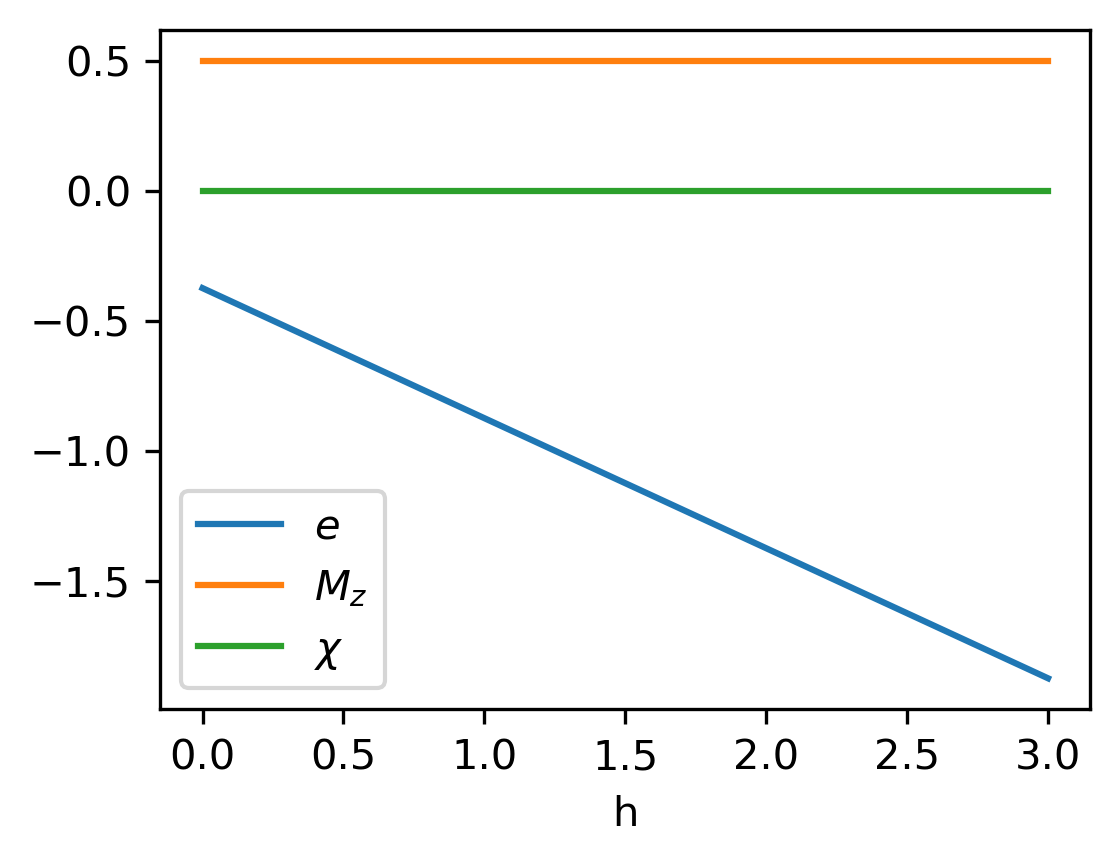

In [36]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(hs, es/3, label=r'$e$')
plt.plot(hs, [mz.expt_value(vs[i]).real for i in range(steps)], label=r'$M_z$')
plt.plot(hs, [chi.expt_value(vs[i]).real for i in range(steps)], label=r'$\chi$')
plt.xlabel('h')
plt.legend()
plt.show()

Well, that's boring! How about we move to a larger cluster?

I know that the 12-site cluster below is usefull because it preserves both rotational and sublattice symmetries, and it's small enough to be easy to work with.

                <4>-<5>
                / \ / \
          <9>-<0>-<1>-<2>-<7>
            \ / \ / \ / \ /
        <5>-<6>-10 -11 -<3>-<4>
          \ / \ / \ / \ / \ /
      <1>-<2>- 7 - 8 - 9 -<0>-<1>
        \ / \ / \ / \ / \ / \ /
    <10-<11- 3 - 4 - 5 - 6 -<10-<11
      \ / \ / \ / \ / \ / \ / \ /
      <8>-<9>- 0 - 1 - 2 -<7>-<8>
          / \ / \ / \ / \ / \
        <5>-<6>-<10-<11-<3>-<4>
              \ / \ / \ /
              <7>-<8>-<9>
              


Now, our lists of neighbors are larger! Gotta love it!

In [37]:
inner_bonds = [[0,1], [1,2], [3,4], [4,5], [5,6], [7,8], [8,9], [10,11], # u
               [0,3], [1,4], [2,5], [4,7], [5,8], [6,9], [8,10], [9,11], # v
               [10,7], [11,8], [7,3], [8,4], [9,5], [4,0], [5,1], [6,2]] # w
outer_bonds = [[2,7], [6,10], [9,0], [11,3], # u
               [11,1], [10,0], [7,6], [3,2], # v
               [3,9], [0,6], [1,10], [2,11]] # w
bonds12 = inner_bonds + outer_bonds

inner_perps = [up for i in range(8)] + [vp for i in range(8)] + [wp for i in range(8)]
outer_perps = [up for i in range(4)] + [vp for i in range(4)] + [wp for i in range(4)]
perps12 = inner_perps + outer_perps

x = np.array([0., 1.]) # unit vectors!
y = np.array([1., 0.])
D = 1
J = 1

In [38]:
steps = 20
hs = np.linspace(0, 1, steps)
D = 1
J = -0.5
basis = spin_basis_1d(12, pauli=0)
es = np.zeros(steps)
vs = np.zeros((steps, basis.Ns), dtype=np.complex128)

In [39]:
for i, h in enumerate(tqdm(hs)):
    H = skyrmion_hamiltonian(D, J, h, 12, bonds12, perps12, basis)
    e, v = H.eigsh(k=1, which='SA')
    es[i] = e[0]
    vs[i] = v[:,0]

100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


In [40]:
mz = Mz_op(12, basis)
# tris = [[0,1,4], [1,2,5], [3,4,7], [4,5,8], [5,6,9], [7,8,10], [8,9,11],
#         [2,7,6], [6,10,0], [9,0,3], [11,3,2], [10,11,1]]
tris = [[0,1,4]]
chi = quantum_operator({'static': [['xyz', [[1,t[0],t[1],t[2]] for t in tris]],
                                   ['xzy', [[-1,t[0],t[1],t[2]] for t in tris]],
                                   ['yzx', [[1,t[0],t[1],t[2]] for t in tris]],
                                   ['yxz', [[-1,t[0],t[1],t[2]] for t in tris]],
                                   ['zxy', [[1,t[0],t[1],t[2]] for t in tris]],
                                   ['zyx', [[-1,t[0],t[1],t[2]] for t in tris]]]}, basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


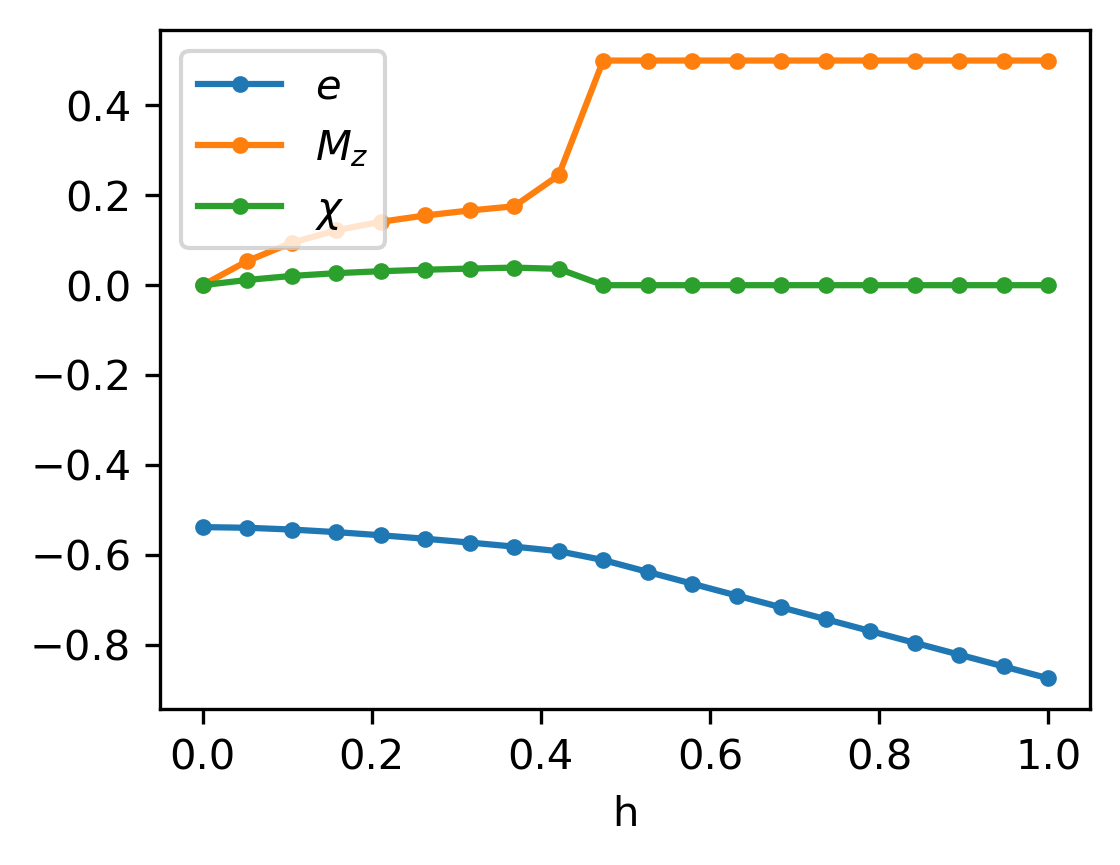

In [41]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(hs, es/12, label=r'$e$', marker='.')
plt.plot(hs, [mz.expt_value(vs[i]).real for i in range(steps)], label=r'$M_z$', marker='.')
plt.plot(hs, [chi.expt_value(vs[i]).real for i in range(steps)], label=r'$\chi$', marker='.')
plt.xlabel('h')
plt.legend()
plt.show()

# 19 site!
          
         <0> <1> <2>
           \   \   \  
      <11> 16 -17 -18 -<3>
         \ / \ / \ / \  
     <6> 12 -13 -14 -15 -<0>
       \ / \ / \ / \ / \   
        7 - 8 - 9 -10 -11 -<16
       / \ / \ / \ / \ /  
    <18>  3 - 4 - 5 - 6 -<12
         / \ / \ / \ /  
      <15>  0 - 1 - 2 -<7
           /   /   /
        <11 <16 <17 
        
It's this one!

In [42]:
inner_bonds = [[0,1], [1,2], 
               [3,4], [4,5], [5,6], 
               [7,8], [8,9], [9,10], [10,11],
               [12,13], [13,14], [14,15],
               [16,17], [17,18], # u
               [0,3], [1,4], [2,5],
               [3,7], [4,8], [5,9], [6,10],
               [8,12], [9,13], [10,14], [11,15],
               [13,16], [14,17], [15,18], # v
               [16,12], [17,13], [18,14],
               [12,7], [13,8], [14,9], [15,10],
               [8,3], [9,4], [10,5], [11,6],
               [4,0], [5,1], [6,2]] # w
outer_bonds = [[2,7], [6,12], [11,16], [15,0], [18,3], # u
               [7,6], [12,11], [16,0], [17,1], [18,2], # v
               [7,18], [3,15], [0,11], [1,16], [2,17]] # w
bonds = inner_bonds + outer_bonds

inner_perps = [up for i in range(14)] + [vp for i in range(14)] + [wp for i in range(14)]
outer_perps = [up for i in range(5)] + [vp for i in range(5)] + [wp for i in range(5)]
perps = inner_perps + outer_perps

x = np.array([0., 1.]) # unit vectors!
y = np.array([1., 0.])
D = 1
J = 1

In [43]:
steps = 20
hs = np.linspace(0, 1, steps)
D = 1
J = -0.5
basis = spin_basis_1d(19, pauli=0)
es = np.zeros(steps)
vs = np.zeros((steps, basis.Ns), dtype=np.complex128)

In [ ]:
for i, h in enumerate(tqdm(hs)):
    H = skyrmion_hamiltonian(D, J, h, 19, bonds, perps, basis)
    e, v = H.eigsh(k=1, which='SA')
    es[i] = e[0]
    vs[i] = v[:,0]

 25%|██▌       | 5/20 [12:07<36:39, 146.66s/it]

In [ ]:
mz = Mz_op(19, basis)
tris = [[2,7,6]]
# tris = [[0,1,4], [1,2,5], [3,4,8], [4,5,9], [5,6,10], 
#         [7,8,12], [8,9,13], [9,10,14], [10,11,15], [12,13,16], [13,14,17], [14,15,18],
#         [2,7,6], [6,12,11], [11,16,0], [15,0,3], [17,18,2], [16,17,1], [18,3,7]] 
c = 19/np.pi
chi = quantum_operator({'static': [['xyz', [[c,t[0],t[1],t[2]] for t in tris]],
                                   ['xzy', [[-c,t[0],t[1],t[2]] for t in tris]],
                                   ['yzx', [[c,t[0],t[1],t[2]] for t in tris]],
                                   ['yxz', [[-c,t[0],t[1],t[2]] for t in tris]],
                                   ['zxy', [[c,t[0],t[1],t[2]] for t in tris]],
                                   ['zyx', [[-c,t[0],t[1],t[2]] for t in tris]]]}, basis=basis)

In [ ]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(hs, es/12, label=r'$e$', marker='.')
plt.plot(hs, [mz.expt_value(vs[i]).real for i in range(steps)], label=r'$M_z$', marker='.')
plt.xlabel('h')
plt.legend()
plt.show()

plt.figure(figsize=(4,3), dpi=300)
plt.plot(hs, [chi.expt_value(vs[i]).real for i in range(steps)], label=r'$\chi$', marker='.')
plt.xlabel('h')
plt.legend()
plt.show()